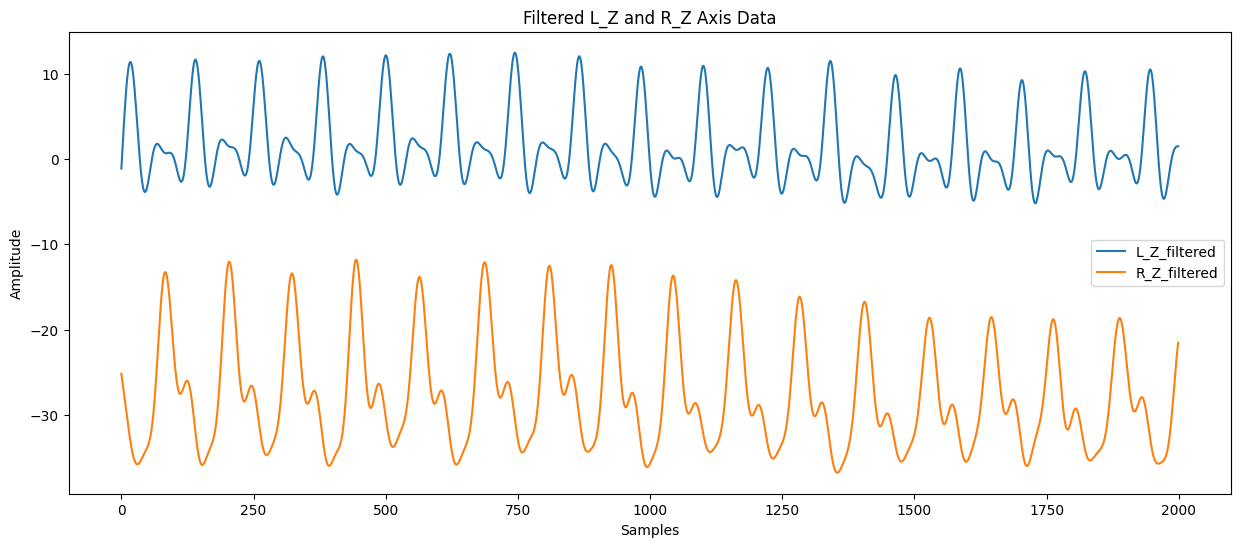

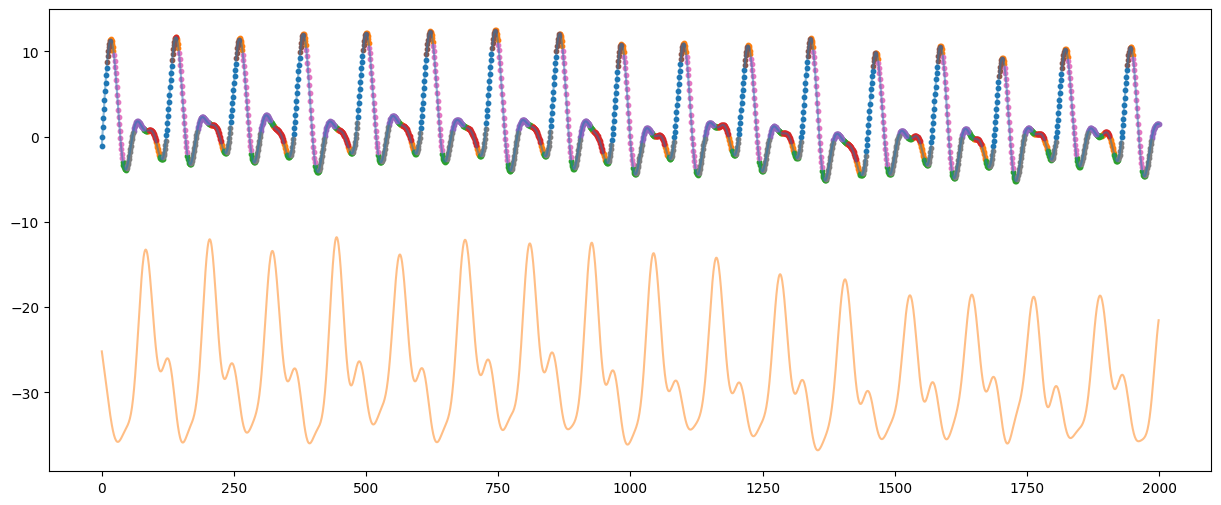

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.cluster import KMeans

# Load the CSV file
file_path = '../data/kineticsProsthesis/1.csv'  # Replace with the actual file path if different
data = pd.read_csv(file_path)

# Skip the first and last 1000 records, then select the middle 2000 records
sampling_rate = 100  # Hz
skip_seconds = 10
skip_records = skip_seconds * sampling_rate
display_records = 2000  # Number of records to display in the middle

filtered_data = data.iloc[skip_records:-skip_records]
mid_index = len(filtered_data) // 2
start_index = max(0, mid_index - display_records // 2)
end_index = min(len(filtered_data), mid_index + display_records // 2)
display_data = filtered_data.iloc[start_index:end_index]

# Extract L_Z and R_Z
L_Z = display_data['L_Z'].values
R_Z = display_data['R_Z'].values

# Apply a low-pass filter to smooth the signal
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
def average_arrays(arrays):
    # Find the maximum length among all arrays
    max_len = max(len(arr) for arr in arrays)
    print(max_len)
    # Pad shorter arrays with zeros to make them equal length
    padded_arrays = [np.pad(arr, (0, max_len - len(arr)), constant_values=777)  for arr in arrays]
    # for arr in padded_arrays:
    #     while len(arr)!=max_len:
    #         arr.append(777)

    # Calculate the average array

    average_array = []
    for i in range(max_len):
        icnt = 0
        sum_at_index = 0
        for arr in padded_arrays:
            if(arr[i] == 777):
                icnt+=1
            else :
                sum_at_index+=arr[i]
        avg_at_index = sum_at_index / (len(arrays)-icnt)
        average_array.append(avg_at_index)

    return average_array
cutoff = 3  # Cutoff frequency in Hz
L_Z_filtered = butter_lowpass_filter(L_Z, cutoff, sampling_rate)
R_Z_filtered = butter_lowpass_filter(R_Z, cutoff, sampling_rate)

# Plot filtered signals
plt.figure(figsize=(15, 6))
plt.plot(L_Z_filtered, label='L_Z_filtered')
plt.plot(R_Z_filtered, label='R_Z_filtered')
plt.legend()
plt.title('Filtered L_Z and R_Z Axis Data')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Feature extraction - first derivative
L_Z_derivative = np.gradient(L_Z_filtered)
R_Z_derivative = np.gradient(R_Z_filtered)

# Identify zero-crossings and turning points
def zero_crossings(data):
    return np.where(np.diff(np.sign(data)))[0]

L_Z_zero_crossings = zero_crossings(L_Z_derivative)
R_Z_zero_crossings = zero_crossings(R_Z_derivative)

# Clustering to identify gait phases
features = np.vstack((L_Z_derivative, R_Z_derivative)).T
kmeans = KMeans(n_clusters=8, n_init=20)  # Assuming 8 gait phases as per the image
kmeans.fit(features)
labels = kmeans.labels_

# Plotting the segmented gait cycle
split_phase = 0

arr = [[] for _ in range(8)]
plt.figure(figsize=(15, 6))
plt.plot(L_Z_filtered, label='L_Z_filtered', alpha=0.5)
plt.plot(R_Z_filtered, label='R_Z_filtered', alpha=0.5)
for phase in range(8):
    phase_indices = np.where(labels == phase)[0]
    arr[phase]= (phase_indices)
    plt.scatter(phase_indices, L_Z_filtered[phase_indices], label=f'Phase {phase}', s=10)
    # arr[phase]


[10, 133, 254, 375, 494, 614, 738, 860, 976, 1095, 1216, 1335, 1459, 1581, 1697, 1816, 1940]
124


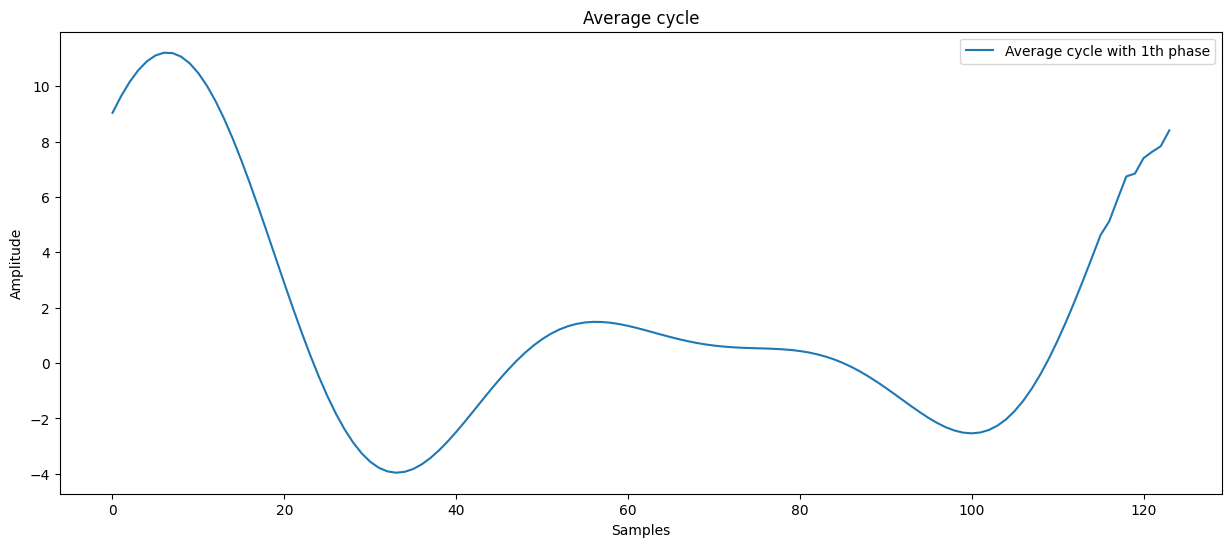

In [84]:
arr.sort(key=lambda x: x[0])
cycles = []
split_points = [arr[split_phase][0]]
for it in range(1, len(arr[split_phase])):
    if arr[split_phase][it-1]+1 != arr[split_phase][it]:
        split_points.append(arr[split_phase][it])
print(split_points)
for i in range(1, len(split_points)):
    cycles.append(L_Z_filtered[split_points[i-1]:split_points[i]])
res = average_arrays(cycles)
plt.figure(figsize=(15, 6))
plt.plot(res, label=f'Average cycle with {split_phase}th phase')
plt.legend()
plt.title('Average cycle')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()